# Tanzanian Water Wells
By Jonathan Nunez

# Business Understanding
As a developing country, Tanzania struggles with providing clean water to its population of over 57,000,000. As it is now, there are many water points that have already been built throughout the country, but some are in need of repair while others have failed altogether.

By using information about the sort of pump, year of installation, etc. I am to build a classifier to predict the condition of a water well or pump as either 'functional' or 'non-functional'. Through the predictions of the model, the government of Tanzania may be able to effectively and efficiently allocate the necessary resources to locations that are in desperate need of repairs.

# Data Understanding
The data used for this project was gathered from [Taarifa](https://taarifa.org/) and [Tanzanian Ministry of Water](https://www.maji.go.tz/). The information that can be found in this data set ranges from the year the pump, water well, etc. was first constructed, to who funded the construction of that specific water source. This dataset also provides an abundance of categorical data, for example longitude/latitude, type of water, etc. In total this dataset holds information on over 50,000 plus water sources ranging from first constructed in 1966 up to 2010, and even water sources that are yet to be fully constructed. Since I am trying to predict which pumps and wells are in need of repairs to provide clean water to its population, I will be primarily focusing on rows and columns for pumps and water wells that have a civilian population who heavily rely on these pumps and wells for water. 

# Data Preparation

In [1]:
# Importing needed tools and modules
import pandas as pd
import numpy as np
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Loading data
tww_data = pd.read_csv('data/training_set_values.csv')
tww_labels = pd.read_csv('data/training_set_labels.csv')

Dropping the 'id' column from the labels data frame as this data frame is sorted in the exact same way as the overall data making it easier to combine both data frames. I also drop columns that are unique identifiers, such as longitude and latitude as data like this doesn't really help with the prediction. There are also columns with different titles but have the same information as a different column minimal variation. For example, the 'quantity' and 'quantity_group', both have the exact information on the how much water remains in the specific water source, so I kept the group column and dropped the other.

In [3]:
# Dropping 'id' column
tww_labels = tww_labels.drop(columns='id')

In [4]:
# Combining the lables data set with overall data
tww_data = pd.concat([tww_data, tww_labels], axis=1)

In [5]:
# Keeping columns that are not unique identifiers, other than 'id'
to_keep = ['id', 'amount_tsh', 'population', 'public_meeting', 'construction_year', 'extraction_type_class', 
           'quantity_group', 'source_type', 'source_class', 'waterpoint_type', 'status_group']

tww_df_keep = tww_data[to_keep]

The 'status_group' column has a 'functional needs repair' value, while the pump can still be considered as 'functional' it is in need of repairs so I replaced all 'functional needs repair' with 'non functional'. In doing so the model will only have two possible results 'functional' or 'non functional'. Changing these values will also help slightly balance out the data. As it is currently, the data is heavily weighted towards 'functional' and that can shift results more towards a ‘functional’ result when in fact the pump could be broken.

In [6]:
# Replacing 'functional needs repair' with 'non functional'
tww_df = tww_df_keep.copy()
tww_df['status_group'] = tww_df['status_group'].replace('functional needs repair', 'non functional')

I also drop rows with a value of 0 in the 'construction_year' column of the data set as well as the 'population' column as this tells me that this specific water pump is yet to be fully constructed, and if the population of where the pump is 0 then that also tells me there is no one around to use the pump and wouldn’t be as high as a priority as compared to a pump with a population of 100+. I also drop rows from the data set where the quantity_group value is 'dry' as a depleted water source won’t see its pump get any use.

In [7]:
# Dropping rows with 0 in 'construction_year' and 'population'
tww_df = tww_df[(tww_df['construction_year'] > 0)]
tww_df = tww_df[(tww_df['population'] > 0)]

In [8]:
# Dropping rows where the quantity_group = 'dry'
tww_df = tww_df[~(tww_df['quantity_group'] == 'dry')]

In the 'public_meeting' column, there are quite a few NaN values. In order to keep as much of this data as possible, I filled in NaN values for 'public_meeting' based on the 'waterpoint_type' values, if it is a communal standpipe (singular or multiple) in the 'waterpoint_type' column then NaN was replaced with True, any other values such as 'hand pump' 'cattle trough', etc. were replaced with False.

In [9]:
tww_df.loc[tww_df['waterpoint_type'] == 'communal standpipe', 'public_meeting'] = True
tww_df.loc[tww_df['waterpoint_type'] == 'communal standpipe multiple', 'public_meeting'] = True
tww_df['public_meeting'] = tww_df['public_meeting'].fillna(False)

In [10]:
tww_df.reset_index(drop=True)

,id,amount_tsh,population,public_meeting,construction_year,extraction_type_class,quantity_group,source_type,source_class,waterpoint_type,status_group
0,69572,6000.0,109,True,1999,gravity,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,280,True,2010,gravity,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,250,True,2009,gravity,enough,dam,surface,communal standpipe multiple,functional
3,9944,20.0,1,True,2009,submersible,enough,other,unknown,communal standpipe multiple,functional
4,49056,0.0,345,True,2011,submersible,enough,borehole,groundwater,other,functional
...,...,...,...,...,...,...,...,...,...,...,...
34124,44885,0.0,210,True,1967,gravity,enough,river/lake,surface,communal standpipe,non functional
34125,11164,500.0,89,True,2007,submersible,enough,borehole,groundwater,communal standpipe,non functional
34126,60739,10.0,125,True,1999,gravity,enough,spring,groundwater,communal standpipe,functional
34127,27263,4700.0,56,True,1996,gravity,enough,river/lake,surface,communal standpipe,functional


# Modeling

### K-Nearest Neighbors (KNN)
The model used for this project is K-Nearest Neighbors (KNN). I went with this classifier as its non-parametric, meaning it doesn’t make assumptions based on how the data is distributed. KNN also adapts easily to new examples or data points. Because data is stored in memory, when there is new data present, it will adjust and incorporate the new information into future predictions.

In [11]:
# Importing needed tools and modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

from imblearn.over_sampling import SMOTE

In [12]:
# Train test splitting data
X = tww_df.drop(['id', 'status_group'], axis=1)
y = tww_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Our data is full of categorical values, in order to be able to use this data with a kNN classifier I first turn the categorical data into numerical values. The following functions taken from the Classification Workflow lecture by Flatiron School, will encode categorical data and return a dataframe with the numerical values. 

In [13]:
# Both encode_and_concat_feature_train, and encode_and_concat_feature taken from Flatiron School lecture
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data. It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps. It Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

encoders = {}


In [14]:
# Onehotencoding categorical data
categorical_feature_names = ['public_meeting', 'extraction_type_class', 'quantity_group', 'source_type', 'source_class',
                             'waterpoint_type']

for categorical_feature in categorical_feature_names:
    ohe, X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe

In [15]:
# Function to quickly get classification scores
def model_eval(y_true, pred):
    '''
    A simple function that takes in train or test data, and prints out its Precision, Recall, and F1-Score.
    
    Arguments:
    y_true: y_train or y_test data
    pred: data that has gone through the .predict() function
    '''
    print('Precision Score: ', precision_score(y_true, pred, average='macro'))
    print('Recall Score: ', recall_score(y_true, pred, average='macro'))
    print('F1-Score: ', f1_score(y_true, pred, average='macro'))

Since our current data is heavily weighted towards the 'functional' status, this can easily cause biases in the model's prediction result. To help lower the model bias as much as possible I use Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic data based off of the data already present to make the data as even as possible. Since KNN is a distance-based machine learning algorithm, I scale the data with a Min Max scaler. I went with a min max scaler to ensure all features are taken into consideration equally and lower the potential of a model bias.

In [16]:
# Balancing Train data
smote = SMOTE()
X_train_resamp, y_train_resamp = smote.fit_resample(X_train, y_train)

In [17]:
# Scaling data
mm_scaler = MinMaxScaler()

In [18]:
mm_scaler.fit(X_train_resamp)

MinMaxScaler()

In [19]:
# Turning our scaled data in a dataframe
X_train_mm_scaled = pd.DataFrame(
    mm_scaler.transform(X_train_resamp),
    index=X_train_resamp.index,
    columns=X_train_resamp.columns
)

### KNN Model 1

In [20]:
knn_1 = KNeighborsClassifier(n_jobs=4)
knn_1.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(n_jobs=4)

In [21]:
y_pred_knn_1 = knn_1.predict(X_train_mm_scaled)

In [22]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_1)

Precision Score:  0.8356378227310999
Recall Score:  0.8346358669340894
F1-Score:  0.8345123623059669


In [23]:
# Cross Validation
print(cross_val_score(knn_1, X_train_mm_scaled, y_train_resamp,))

[0.718361   0.72838866 0.71715076 0.80753934 0.82569601]


### KNN Model 2

In [88]:
# KNN model 2
knn_2 = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', n_jobs=4, metric='l1')
knn_2.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_jobs=4,
                     n_neighbors=9)

In [89]:
y_pred_knn_2 = knn_2.predict(X_train_mm_scaled)

In [90]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_2)

Precision Score:  0.8120687239441204
Recall Score:  0.809668718445259
F1-Score:  0.8093020715805527


In [91]:
# Cross Validation
print(cross_val_score(knn_2, X_train_mm_scaled, y_train_resamp,))

[0.71801521 0.7238935  0.72130014 0.79906623 0.8071935 ]


### KNN Model 3

In [100]:
# KNN model 3
knn_3 = KNeighborsClassifier(n_neighbors=17, weights='uniform', n_jobs=4, algorithm='kd_tree', leaf_size=20, metric='minkowski')
knn_3.fit(X_train_mm_scaled, y_train_resamp)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=20, n_jobs=4,
                     n_neighbors=17)

In [101]:
y_pred_knn_3 = knn_3.predict(X_train_mm_scaled)

In [102]:
# Checking model scores
model_eval(y_train_resamp, y_pred_knn_3)

Precision Score:  0.7870163852906016
Recall Score:  0.7842520229614773
F1-Score:  0.7837312817002855


In [103]:
# Cross Validation
print(cross_val_score(knn_3, X_train_mm_scaled, y_train_resamp))

[0.72095436 0.71196404 0.72026279 0.79145772 0.81013315]


### Confusion Matrix Plots

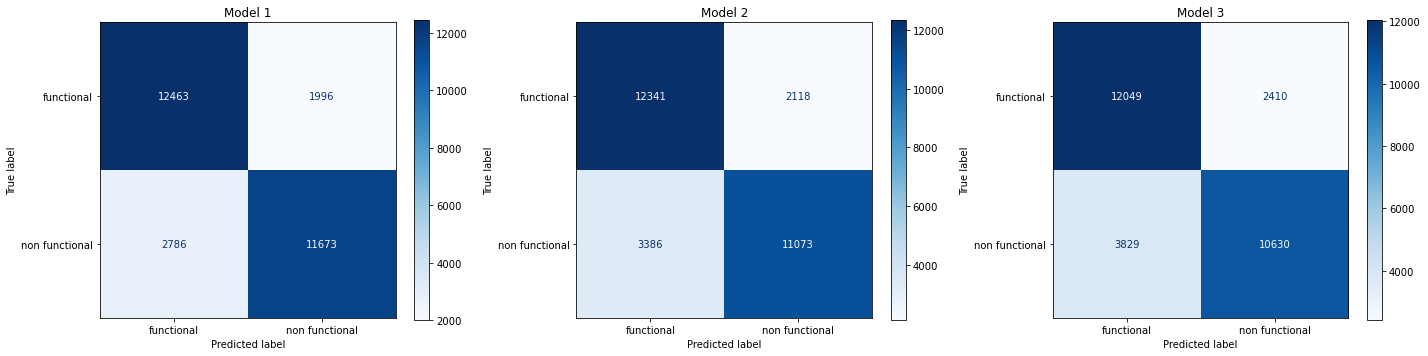

In [104]:
fix, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axes[0].set_title('Model 1')
axes[1].set_title('Model 2')
axes[2].set_title('Model 3')

plot_confusion_matrix(knn_1, X_train_mm_scaled, y_train_resamp,
                      ax=axes[0], cmap='Blues')
plot_confusion_matrix(knn_2, X_train_mm_scaled, y_train_resamp,
                      ax=axes[1], cmap='Blues')
plot_confusion_matrix(knn_3, X_train_mm_scaled, y_train_resamp,
                      ax=axes[2], cmap='Blues')
plt.tight_layout();

### Receiver Operating Characteristic Curve Plot

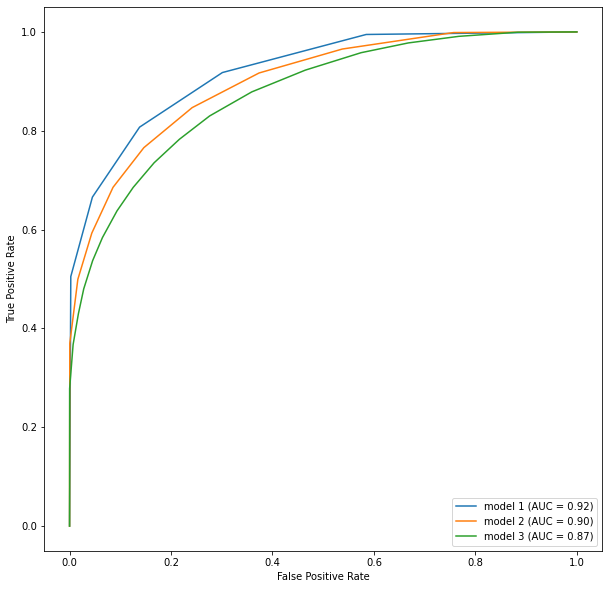

In [105]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_roc_curve(knn_1, X_train_mm_scaled, y_train_resamp, 
               name='model 1', ax=ax)
plot_roc_curve(knn_2, X_train_mm_scaled, y_train_resamp, 
               name='model 2', ax=ax)
plot_roc_curve(knn_3, X_train_mm_scaled, y_train_resamp, 
               name='model 3', ax=ax);

### KNN Final Model

In [34]:
# Preparing Test data for model use
for categorical_feature in categorical_feature_names:
    ohe, X_test = encode_and_concat_feature_train(X_test, categorical_feature)
    encoders[categorical_feature] = ohe

In [35]:
# Balancing Test data
X_test_resamp, y_test_resamp = smote.fit_resample(X_test, y_test)

In [36]:
# Fitting resampled data to scaler
mm_scaler.fit(X_test_resamp)

MinMaxScaler()

In [37]:
# Turning scaled data back into dataframe
X_test_mm_scaled = pd.DataFrame(
    mm_scaler.transform(X_test_resamp),
    index=X_test_resamp.index,
   columns=X_test_resamp.columns
)

In [106]:
# Final model
knn_final = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', n_jobs=4, metric='l1')
knn_final.fit(X_test_mm_scaled, y_test_resamp)

KNeighborsClassifier(algorithm='ball_tree', metric='l1', n_jobs=4,
                     n_neighbors=9)

In [107]:
y_pred_knn_final = knn_final.predict(X_test_mm_scaled)

In [108]:
model_eval(y_test_resamp, y_pred_knn_final)

Precision Score:  0.7996600070416179
Recall Score:  0.796895213454075
F1-Score:  0.7964256470685489


In [109]:
print(cross_val_score(knn_final, X_test_mm_scaled, y_test_resamp,))

[0.69886823 0.69442199 0.7069523  0.77355439 0.79822078]


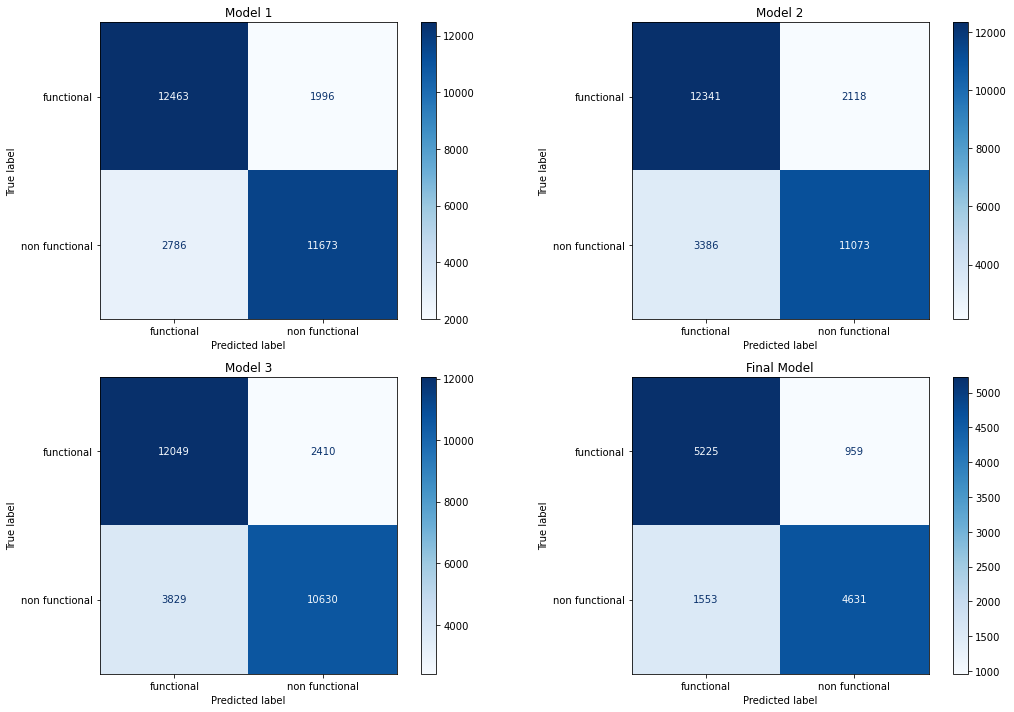

In [110]:
fix, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

axes[0, 0].set_title("Model 1")
axes[0, 1].set_title("Model 2")
axes[1, 0].set_title("Model 3")
axes[1, 1].set_title("Final Model")

plot_confusion_matrix(knn_1, X_train_mm_scaled, y_train_resamp,
                      ax=axes[0, 0], cmap='Blues')
plot_confusion_matrix(knn_2, X_train_mm_scaled, y_train_resamp,
                      ax=axes[0, 1], cmap='Blues')
plot_confusion_matrix(knn_3, X_train_mm_scaled, y_train_resamp,
                      ax=axes[1, 0], cmap='Blues')
plot_confusion_matrix(knn_final, X_test_mm_scaled, y_test_resamp,
                      ax=axes[1, 1], cmap='Blues')
plt.tight_layout();

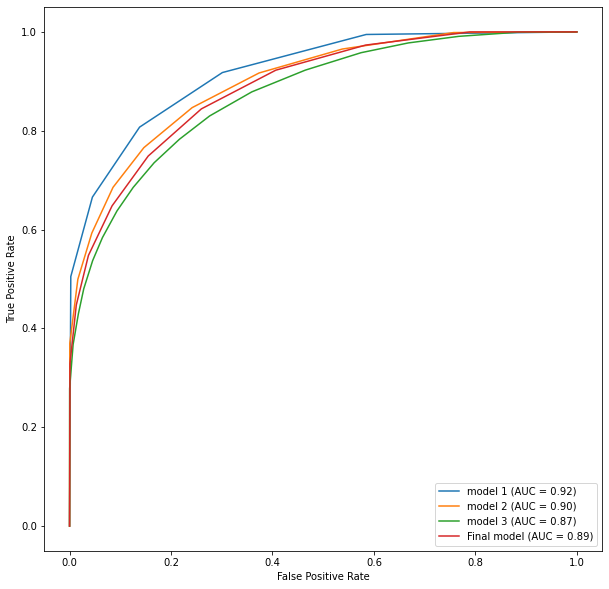

In [111]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_roc_curve(knn_1, X_train_mm_scaled, y_train_resamp, 
               name='model 1', ax=ax)
plot_roc_curve(knn_2, X_train_mm_scaled, y_train_resamp, 
               name='model 2', ax=ax)
plot_roc_curve(knn_3, X_train_mm_scaled, y_train_resamp, 
               name='model 3', ax=ax)
plot_roc_curve(knn_final, X_test_mm_scaled, y_test_resamp, 
               name='Final model', ax=ax);

# Evaluation

# Conclusion

## Limitation

## Recomendations

## Next Steps